# Библиотеки для решения задачи

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

# Быстрое матрично-векторное умножение

In [7]:
def fast_bbtmv_mul(col_arr,
                   row_arr,
                   vec_arr,
                   n, m, k):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:
    :param n:
    :param m:
    :param k:
    :return:
    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j

    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]

    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifft(circulant_tensor)

    return circulant_tensor[:n, :m, :k]


def prep_fftbbtensor(col_arr,
                     row_arr,
                     n, m, k):
    """

    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    col_arr = col_arr.reshape((n, m, k))
    row_arr = row_arr.reshape((n, m, k))
    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    return circulant_tensor


def prep_fbbtmv(prep_fft_arr,
                vec_arr,
                n, m, k):
    """

    """
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]
    prep_fft_arr = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))
    return prep_fft_arr[:n, :m, :k]

# Сетка для прямоугольной области решения

In [8]:
def make_grid(N, L, center, **kwargs):
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
#     # Сетка - трехмерный тензор
#     grid_mesh = np.stack(np.meshgrid(x,y,z), axis=-1)
#     #grid = np.stack([grid_mesh[1], grid_mesh[0], grid_mesh[2]], axis=-1)
#     grid = grid_mesh.reshape(-1, 3)
    grid = np.array(np.meshgrid(x, y, z, indexing='xy')).T.reshape(-1, 3)[:, [1, 0, 2]]
    
    return grid, volume

# Вспомогательная программа для определения индекса диэлектрической проницаемости среды

In [9]:
def step_dielectric_3d(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric_3d(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric_3d(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric_3d(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric_3d(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes

# Определение ядра интегрального оператора

In [10]:
def kernel(x, k=1, **kwargs):
    return np.exp(1j * k * x)/(4 * np.pi * x)

# Функция внешней плоской волны 

В общем случае плоские волны, распространяющиеся в произвольном направлении, имеют вид

$$
\vec{E} = \vec{E}_{max} exp(1i \cdot \vec{k}\vec{r} - \phi_0)
$$

In [11]:
def wave(x, k=1, orient=[0.0, 0.0, 1.0], sign=1, amplitude=[1.0, 0.0, 0.0], phi0=0.0, **kwargs):
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    amplitude = np.array(amplitude)
    return amplitude.reshape(-1, 3) * np.exp(sign * 1j * k * (x.dot(orient)) - phi0).reshape(-1, 1)

# Оператор объемного сингулярного интегрального уравнения

$$
    B_{nm}(p-q) = \int_{\Pi_q} G(R) \left[(\frac{3}{R^2} - \frac{3ik_0}{R} - k_0^2)\alpha_n \alpha_m + (k_0^2 + \frac{ik_0}{R}-\frac{1}{R^2})\delta_{nm} \right] dy, p\ne q
$$

$$
\alpha_n = \frac{x_n(p)-y_n}{|x(p)-y|}, n=1,2,3, \quad \eta_{mk} = \varepsilon(y(q)) - \delta_{mk}, \quad R = \sqrt{\sum_{i=1}^{3} {(y_i - x_i(p))^2}}, \quad B_{nm}(0,0,0) = (-1/3)I
$$



In [12]:
def init_operator(grid, volume, discret, distance, k, eps, kernel):
    dist_coef_1 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_1[1:] = (3 / (distance[1:] ** 2)) - ((3j * k) / distance[1:]) - (k ** 2)
    alpha = np.zeros((np.prod(discret), 3))
    alpha[1:, :] = (grid[0, :] - grid[1:, :]) / distance[1:].reshape(-1, 1)
    indexing_matrix = np.einsum('...j,...i->...ji', alpha, alpha)
    part_1 = indexing_matrix * dist_coef_1.reshape(-1, 1, 1)

    dist_coef_2 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_2[1:] = (k ** 2) + ((1j * k) / distance[1:]) - (1 / (distance[1:] ** 2))
    part_2 = np.eye(3).reshape(-1, 3, 3) * dist_coef_2.reshape(-1, 1, 1)

    gr = np.zeros(np.prod(discret)) + 0.0j
    gr[1:] = kernel(distance[1:], k)
    result = gr.reshape(-1, 1, 1) * (part_1 + part_2) * volume.reshape(-1, 1)
    eps = eps.reshape(-1, 3, 3) - (np.eye(3).reshape(-1, 3, 3))
    result[0, :, :] = -(1 / 3) * np.eye(3)
    return result, gr, eps

# Оператор

In [13]:
def operator(operator_array, vector_array, eps, n, m, k):
    result = np.zeros((n * m * k, 3)) + 0.0j
    vec_array = np.einsum("...ijk,...ij->...ik", eps, vector_array)
    for col in range(3):
        res = prep_fbbtmv(prep_fft_arr=operator_array[:, col].reshape((2 * n, 2 * m, 2 * k)),
                          vec_arr=vec_array[:, col].reshape((n, m, k)),
                          n=n, m=m, k=k).reshape((-1,))
        result[:, 0] += res
    for col in range(3):
        result[:, 1] += prep_fbbtmv(prep_fft_arr=operator_array[:, 3 + col].reshape((2 * n, 2 * m, 2 * k)),
                                    vec_arr=vec_array[:, col].reshape((n, m, k)),
                                    n=n, m=m, k=k).reshape((-1,))
    for col in range(3):
        result[:, 2] += prep_fbbtmv(prep_fft_arr=operator_array[:, 6 + col].reshape((2 * n, 2 * m, 2 * k)),
                                    vec_arr=vec_array[:, col].reshape((n, m, k)),
                                    n=n, m=m, k=k).reshape((-1,))

    result = vector_array - result
    return result


def conj_operator(operator_array, vector_array, eps, n, m, k):
    result = np.zeros((n * m * k, 3)) + 0.0j
    for col in range(3):
        res = prep_fbbtmv(prep_fft_arr=operator_array[:, col].reshape((2 * n, 2 * m, 2 * k)),
                          vec_arr=vector_array[:, col].reshape((n, m, k)),
                          n=n, m=m, k=k).reshape((-1,))
        result[:, 0] += res
    for col in range(3):
        result[:, 1] += prep_fbbtmv(prep_fft_arr=operator_array[:, 3 + col].reshape((2 * n, 2 * m, 2 * k)),
                                    vec_arr=vector_array[:, col].reshape((n, m, k)),
                                    n=n, m=m, k=k).reshape((-1,))
    for col in range(3):
        result[:, 2] += prep_fbbtmv(prep_fft_arr=operator_array[:, 6 + col].reshape((2 * n, 2 * m, 2 * k)),
                                    vec_arr=vector_array[:, col].reshape((n, m, k)),
                                    n=n, m=m, k=k).reshape((-1,))
    result = np.einsum("...ijk,...ij->...ik", np.conj(eps), result)
    result = vector_array - result
    return result

# Метод простой итерации

In [74]:
def SIM(prep_fourier_oper, vector_f, vector_nu, param_mu, 
            z_0=None, n_1=20, n_2=20, n_3=20, rtol=10e-8, max_iter=None):
    if max_iter is None:
        max_iter=100
    if z_0 is None:
        z_0 = np.zeros(vector_f.shape) + 0.0j
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Норма вектора свободных коэффициентов
    f_norm = np.sqrt(complex_norm(vector_f))
    
    for it in range(1, max_iter):
        resid = operator(prep_fourier_oper, z_0, vector_nu, n_1, n_2, n_3) - vector_f
        z_1 = z_0 - 1/param_mu * (resid)
        eps = complex_norm(z_1 - z_0) / f_norm
        iters_list.append(it)
        eps_list.append(eps)
        resid_list.append(complex_norm(resid))
        print(f'Итерация №{it}: Умножений М-В L = {iters_list[-1]}, \nУмножений В-В V = {it}, \nКритерий останова eps = {eps_list[-1]},\nНевязка итераций resid={resid_list[-1]}\n')
        if eps < rtol:
            break
        z_0 = z_1 * 1.0
        
    return z_1, iters_list, eps_list, resid_list

# Двухшаговый метод градиентного спуска

In [34]:
def complex_norm(a):
    return np.sum(a * np.conj(a)).real

def TwoStep(prep_fourier_oper, prep_conj_oper, vector_f, vector_nu, 
            z_0=None, n_1=20, n_2=20, n_3=20, rtol=10e-8, max_iter=None):
    
    if max_iter is None:
        max_iter=100
    if z_0 is None:
        z_0 = np.zeros(vector_f.shape) + 0.0j
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Норма вектора свободных коэффициентов
    f_norm = np.sqrt(complex_norm(vector_f))
    
    # Итерационный процесс
    l_0 = operator(prep_fourier_oper, z_0, vector_nu, n_1, n_2, n_3)
    r_0 = l_0 - vector_f
    l_1 = conj_operator(prep_conj_oper, r_0, vector_nu, n_1, n_2, n_3)
    l_2 = operator(prep_fourier_oper, l_1, vector_nu, n_1, n_2, n_3)
    z_1 = z_0 - complex_norm(l_1) / complex_norm(l_2) * l_1
    
    # Расчет критерия останова
    eps = np.sqrt(complex_norm(z_1 - z_0)) / f_norm
    
    # Пополнение списков для логов итераций
    iters_list.append(3)
    eps_list.append(eps)
    resid_list.append(complex_norm(r_0))
    print(f'Итерация №1: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {4}, Критерий останова eps = {eps_list[-1]}')
    if (eps < rtol):
        return z_1, iters_list, eps_list, resid_list 
    
    # Цикл, если 
    for it in range(2, max_iter+1):
        l_0 = operator(prep_fourier_oper, z_1, vector_nu, n_1, n_2, n_3)
        r_k = l_0 - vector_f
        l_1 = conj_operator(prep_conj_oper, r_k, vector_nu, n_1, n_2, n_3)
        l_2 = operator(prep_fourier_oper, l_1, vector_nu, n_1, n_2, n_3)
        
        delta_rk = r_k - r_0
        a_0 = complex_norm(delta_rk)
        a_1 = complex_norm(l_1)
        a_2 = complex_norm(l_2)
        
        det = (a_0 * a_2 - a_1 * a_1)
        t_k = -(a_1 * a_1) / det
        h_k = (a_0 * a_1) / det
        
        z_k = z_1 - t_k * (z_1 - z_0) - h_k * l_1
        
        eps = np.sqrt(complex_norm(z_k - z_1)) / f_norm 
        
        iters_list.append(iters_list[-1] + 3)
        eps_list.append(eps)
        resid_list.append(complex_norm(r_k))

        print(f'Итерация №{it}: Умножений М-В L = {iters_list[-1]}, \nУмножений В-В V = {it*4}, \nКритерий останова eps = {eps_list[-1]},\nНевязка итераций resid={resid_list[-1]}\n')
        if (eps < rtol):
            break
        
        r_0 = np.copy(r_k)
        z_0 = np.copy(z_1)
        z_1 = np.copy(z_k)
    return z_k, iters_list, eps_list, resid_list

In [35]:
def compute_RCS(result_s, eps_on_grid, grid, in_Q, volume, k_0, n_phi):
    epsilon = 1e-6
    angles = np.linspace(-np.pi+epsilon, np.pi-epsilon, n_phi)
    vectors_xy = np.hstack([
        np.cos(angles).reshape((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1)),    
        np.zeros((n_phi, 1))
        ])
    vectors_yz = np.hstack([
        np.zeros((n_phi, 1)),
        np.cos(angles).reshape((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1))
        ])
    vectors_xz = np.hstack([
        np.cos(angles).reshape((n_phi, 1)),
        np.zeros((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1)),
        ])
    result_list = []
    angles_list = []
    for vectors in [vectors_xy, vectors_yz, vectors_xz]:
        s_q = np.einsum('...ji,...i->...j', eps_on_grid-np.eye(3).reshape(-1, 3, 3), result_s)
        cross_matrix_e_r = np.einsum("...ij,...kj->...ik", grid, vectors)
        waves = np.exp(1j * k_0 * cross_matrix_e_r) * (in_Q.reshape(-1, 1) * volume)
        result = np.einsum('...ij,...ik->jk', waves, s_q)
        result = (k_0**4) / (16 * np.pi**2) * np.power(np.linalg.norm(np.cross(vectors, result), 2, axis=1), 2)
        result_list.append(result)
        angles_list.append(angles)
    return result_list, angles_list

In [36]:
def plot_cube_scatter(grid, points, save_to=None, show=True):
    if save_to is None:
        save_to = "output\\"

    fig = plt.figure(figsize=(9, 9), dpi=256)
    ax = fig.add_subplot(projection='3d')

    ax.scatter(grid[:, 0], grid[:, 1], grid[:, 2], c=points)
    ax.set_xlabel(fr"$X_1$ axis", fontsize=16)
    ax.set_ylabel(fr"$X_2$ axis", fontsize=16)
    ax.set_zlabel(fr"$X_3$ axis", fontsize=16)

    plt.savefig(save_to)
    if show:
        plt.show()

# Скрипт решения задачи

In [124]:
# Конфиг задачи
problem_config = {
    'N': [20, 20, 20],
    'L': [1.0, 1.0, 1.0],
    'center': [0.0, 0.0, 0.0],
    'k': 0.2,
    'orient': [0.0, 1.0, 0.0],
    'amplitude': [1.0, 0.0, 0.0],
    'sign': 1.0,
    'eps_vec': [
        {
                "type": "step",
                "eps_real": [[5.0, 0.0, 0.0],
                             [0.0, 3.0, 0.0],
                             [0.0, 0.0, 2.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 1.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]
k_wave = problem_config.get('k')

In [125]:
grid, vol = make_grid(**problem_config)
dists = np.linalg.norm(grid[0, :] - grid[:,:], 2, axis=1) 
eta, ind = apply_dielectric_3d(grid, **problem_config)

In [126]:
G, gr, eps = init_operator(grid, vol, problem_config.get('N'), dists, problem_config.get('k'), eta, kernel)

In [127]:
oper_coeffs = G.reshape((-1, 9))

prep_coeffs = np.zeros((8 * n_1 * n_2 * n_3, 9)) + 0.0j
for rowcol in range(9):
    prep_coeffs[:, rowcol] = prep_fftbbtensor(col_arr=oper_coeffs[:, rowcol],
                                              row_arr=oper_coeffs[:, rowcol],
                                              n=n_1,
                                              m=n_2,
                                              k=n_3).reshape((8 * n_1 * n_2 * n_3,))

prep_compl_coeffs = np.zeros((8 * n_1 * n_2 * n_3, 9)) + 0.0j
for rowcol in range(9):
    prep_compl_coeffs[:, rowcol] = prep_fftbbtensor(col_arr=np.conj(oper_coeffs)[:, rowcol],
                                                  row_arr=np.conj(oper_coeffs)[:, rowcol],
                                                  n=n_1,
                                                  m=n_2,
                                                  k=n_3).reshape((8 * n_1 * n_2 * n_3,))

In [128]:
f_wave = wave(x=grid,
                k_0=float(k_wave),
                direction=np.array(problem_config.get('orient')),
                amplitude=np.array(problem_config.get('amplitude')))

In [122]:
result_SIM, iters_SIM, eps_SIM, resid_SIM = SIM(prep_coeffs, f_wave, eta, param_mu=150, 
                                                z_0=None, 
                                                n_1=n_1, n_2=n_2, n_3=n_3, 
                                                rtol=10e-8, max_iter=10)

Итерация №1: Умножений М-В L = 1, 
Умножений В-В V = 1, 
Критерий останова eps = 0.003975231959999627,
Невязка итераций resid=8000.0

Итерация №2: Умножений М-В L = 2, 
Умножений В-В V = 2, 
Критерий останова eps = 0.0038481319051989933,
Невязка итераций resid=7744.216073769652

Итерация №3: Умножений М-В L = 3, 
Умножений В-В V = 3, 
Критерий останова eps = 0.0037533762745338736,
Невязка итераций resid=7553.524045493388

Итерация №4: Умножений М-В L = 4, 
Умножений В-В V = 4, 
Критерий останова eps = 0.0036895286785373544,
Невязка итераций resid=7425.033237130043

Итерация №5: Умножений М-В L = 5, 
Умножений В-В V = 5, 
Критерий останова eps = 0.0036553664784657225,
Невязка итераций resid=7356.283135671038

Итерация №6: Умножений М-В L = 6, 
Умножений В-В V = 6, 
Критерий останова eps = 0.0036498682520129683,
Невязка итераций resid=7345.218168377398

Итерация №7: Умножений М-В L = 7, 
Умножений В-В V = 7, 
Критерий останова eps = 0.0036722027654076516,
Невязка итераций resid=7390.1655

In [129]:
result, iters, eps, resid = TwoStep(prep_coeffs, prep_compl_coeffs, f_wave, eta, z_0=None, n_1=n_1, n_2=n_2, n_3=n_3, rtol=10e-8, max_iter=300)

Итерация №1: Умножений М-В L = 3, Умножений В-В V = 4, Критерий останова eps = 0.1287205467756752
Итерация №2: Умножений М-В L = 6, 
Умножений В-В V = 8, 
Критерий останова eps = 0.10494432996018561,
Невязка итераций resid=3290.7458792384236

Итерация №3: Умножений М-В L = 9, 
Умножений В-В V = 12, 
Критерий останова eps = 0.07331578272515918,
Невязка итераций resid=1183.0431570658125

Итерация №4: Умножений М-В L = 12, 
Умножений В-В V = 16, 
Критерий останова eps = 0.028487000636234803,
Невязка итераций resid=511.5622765388978

Итерация №5: Умножений М-В L = 15, 
Умножений В-В V = 20, 
Критерий останова eps = 0.06718354557067353,
Невязка итераций resid=393.8896072121235

Итерация №6: Умножений М-В L = 18, 
Умножений В-В V = 24, 
Критерий останова eps = 0.020991605237510938,
Невязка итераций resid=229.57929911703337

Итерация №7: Умножений М-В L = 21, 
Умножений В-В V = 28, 
Критерий останова eps = 0.022973506256031197,
Невязка итераций resid=193.80210762720282

Итерация №8: Умножений

Итерация №57: Умножений М-В L = 171, 
Умножений В-В V = 228, 
Критерий останова eps = 0.006761905371893458,
Невязка итераций resid=24.368572062374945

Итерация №58: Умножений М-В L = 174, 
Умножений В-В V = 232, 
Критерий останова eps = 0.007495347737495182,
Невязка итераций resid=24.07060280721775

Итерация №59: Умножений М-В L = 177, 
Умножений В-В V = 236, 
Критерий останова eps = 0.010284530542776633,
Невязка итераций resid=23.75102007462236

Итерация №60: Умножений М-В L = 180, 
Умножений В-В V = 240, 
Критерий останова eps = 0.009441880673214297,
Невязка итераций resid=23.325580837040185

Итерация №61: Умножений М-В L = 183, 
Умножений В-В V = 244, 
Критерий останова eps = 0.0072093906004996626,
Невязка итераций resid=22.94390408306407

Итерация №62: Умножений М-В L = 186, 
Умножений В-В V = 248, 
Критерий останова eps = 0.005357699563252542,
Невязка итераций resid=22.659072790240774

Итерация №63: Умножений М-В L = 189, 
Умножений В-В V = 252, 
Критерий останова eps = 0.00520489

Итерация №113: Умножений М-В L = 339, 
Умножений В-В V = 452, 
Критерий останова eps = 0.00928913567111884,
Невязка итераций resid=15.666514754253395

Итерация №114: Умножений М-В L = 342, 
Умножений В-В V = 456, 
Критерий останова eps = 0.012507824091822576,
Невязка итераций resid=15.549579362067957

Итерация №115: Умножений М-В L = 345, 
Умножений В-В V = 460, 
Критерий останова eps = 0.011770174706229548,
Невязка итераций resid=15.392994813474516

Итерация №116: Умножений М-В L = 348, 
Умножений В-В V = 464, 
Критерий останова eps = 0.011352556822670517,
Невязка итераций resid=15.246451938201762

Итерация №117: Умножений М-В L = 351, 
Умножений В-В V = 468, 
Критерий останова eps = 0.012727514595306882,
Невязка итераций resid=15.105799434585503

Итерация №118: Умножений М-В L = 354, 
Умножений В-В V = 472, 
Критерий останова eps = 0.007896959572601723,
Невязка итераций resid=14.948900227105513

Итерация №119: Умножений М-В L = 357, 
Умножений В-В V = 476, 
Критерий останова eps = 0.

Итерация №167: Умножений М-В L = 501, 
Умножений В-В V = 668, 
Критерий останова eps = 0.004937094584707503,
Невязка итераций resid=10.866752584243336

Итерация №168: Умножений М-В L = 504, 
Умножений В-В V = 672, 
Критерий останова eps = 0.004318488642378014,
Невязка итераций resid=10.82577194917716

Итерация №169: Умножений М-В L = 507, 
Умножений В-В V = 676, 
Критерий останова eps = 0.0039584059002615675,
Невязка итераций resid=10.790275174415385

Итерация №170: Умножений М-В L = 510, 
Умножений В-В V = 680, 
Критерий останова eps = 0.003313019244256607,
Невязка итераций resid=10.758144829325

Итерация №171: Умножений М-В L = 513, 
Умножений В-В V = 684, 
Критерий останова eps = 0.003579482969479638,
Невязка итераций resid=10.731616935328745

Итерация №172: Умножений М-В L = 516, 
Умножений В-В V = 688, 
Критерий останова eps = 0.0033504675915703754,
Невязка итераций resid=10.703316677282098

Итерация №173: Умножений М-В L = 519, 
Умножений В-В V = 692, 
Критерий останова eps = 0.0

Итерация №221: Умножений М-В L = 663, 
Умножений В-В V = 884, 
Критерий останова eps = 0.0034394156945973813,
Невязка итераций resid=9.893035452231443

Итерация №222: Умножений М-В L = 666, 
Умножений В-В V = 888, 
Критерий останова eps = 0.004307988233110837,
Невязка итераций resid=9.877694694872368

Итерация №223: Умножений М-В L = 669, 
Умножений В-В V = 892, 
Критерий останова eps = 0.00445689744833835,
Невязка итераций resid=9.858591735243182

Итерация №224: Умножений М-В L = 672, 
Умножений В-В V = 896, 
Критерий останова eps = 0.004155551956188167,
Невязка итераций resid=9.83893145180582

Итерация №225: Умножений М-В L = 675, 
Умножений В-В V = 900, 
Критерий останова eps = 0.0036264199521720245,
Невязка итераций resid=9.82071032482861

Итерация №226: Умножений М-В L = 678, 
Умножений В-В V = 904, 
Критерий останова eps = 0.00402989865854619,
Невязка итераций resid=9.804887950023849

Итерация №227: Умножений М-В L = 681, 
Умножений В-В V = 908, 
Критерий останова eps = 0.0042266

Итерация №277: Умножений М-В L = 831, 
Умножений В-В V = 1108, 
Критерий останова eps = 0.005983602848617131,
Невязка итераций resid=8.665284507149806

Итерация №278: Умножений М-В L = 834, 
Умножений В-В V = 1112, 
Критерий останова eps = 0.006835205486653474,
Невязка итераций resid=8.64406808052325

Итерация №279: Умножений М-В L = 837, 
Умножений В-В V = 1116, 
Критерий останова eps = 0.0061745767290061855,
Невязка итераций resid=8.619901266028073

Итерация №280: Умножений М-В L = 840, 
Умножений В-В V = 1120, 
Критерий останова eps = 0.006774636380553756,
Невязка итераций resid=8.598136246220195

Итерация №281: Умножений М-В L = 843, 
Умножений В-В V = 1124, 
Критерий останова eps = 0.0074296482351925534,
Невязка итераций resid=8.574326536937523

Итерация №282: Умножений М-В L = 846, 
Умножений В-В V = 1128, 
Критерий останова eps = 0.007412757488269723,
Невязка итераций resid=8.548292157694707

Итерация №283: Умножений М-В L = 849, 
Умножений В-В V = 1132, 
Критерий останова eps =

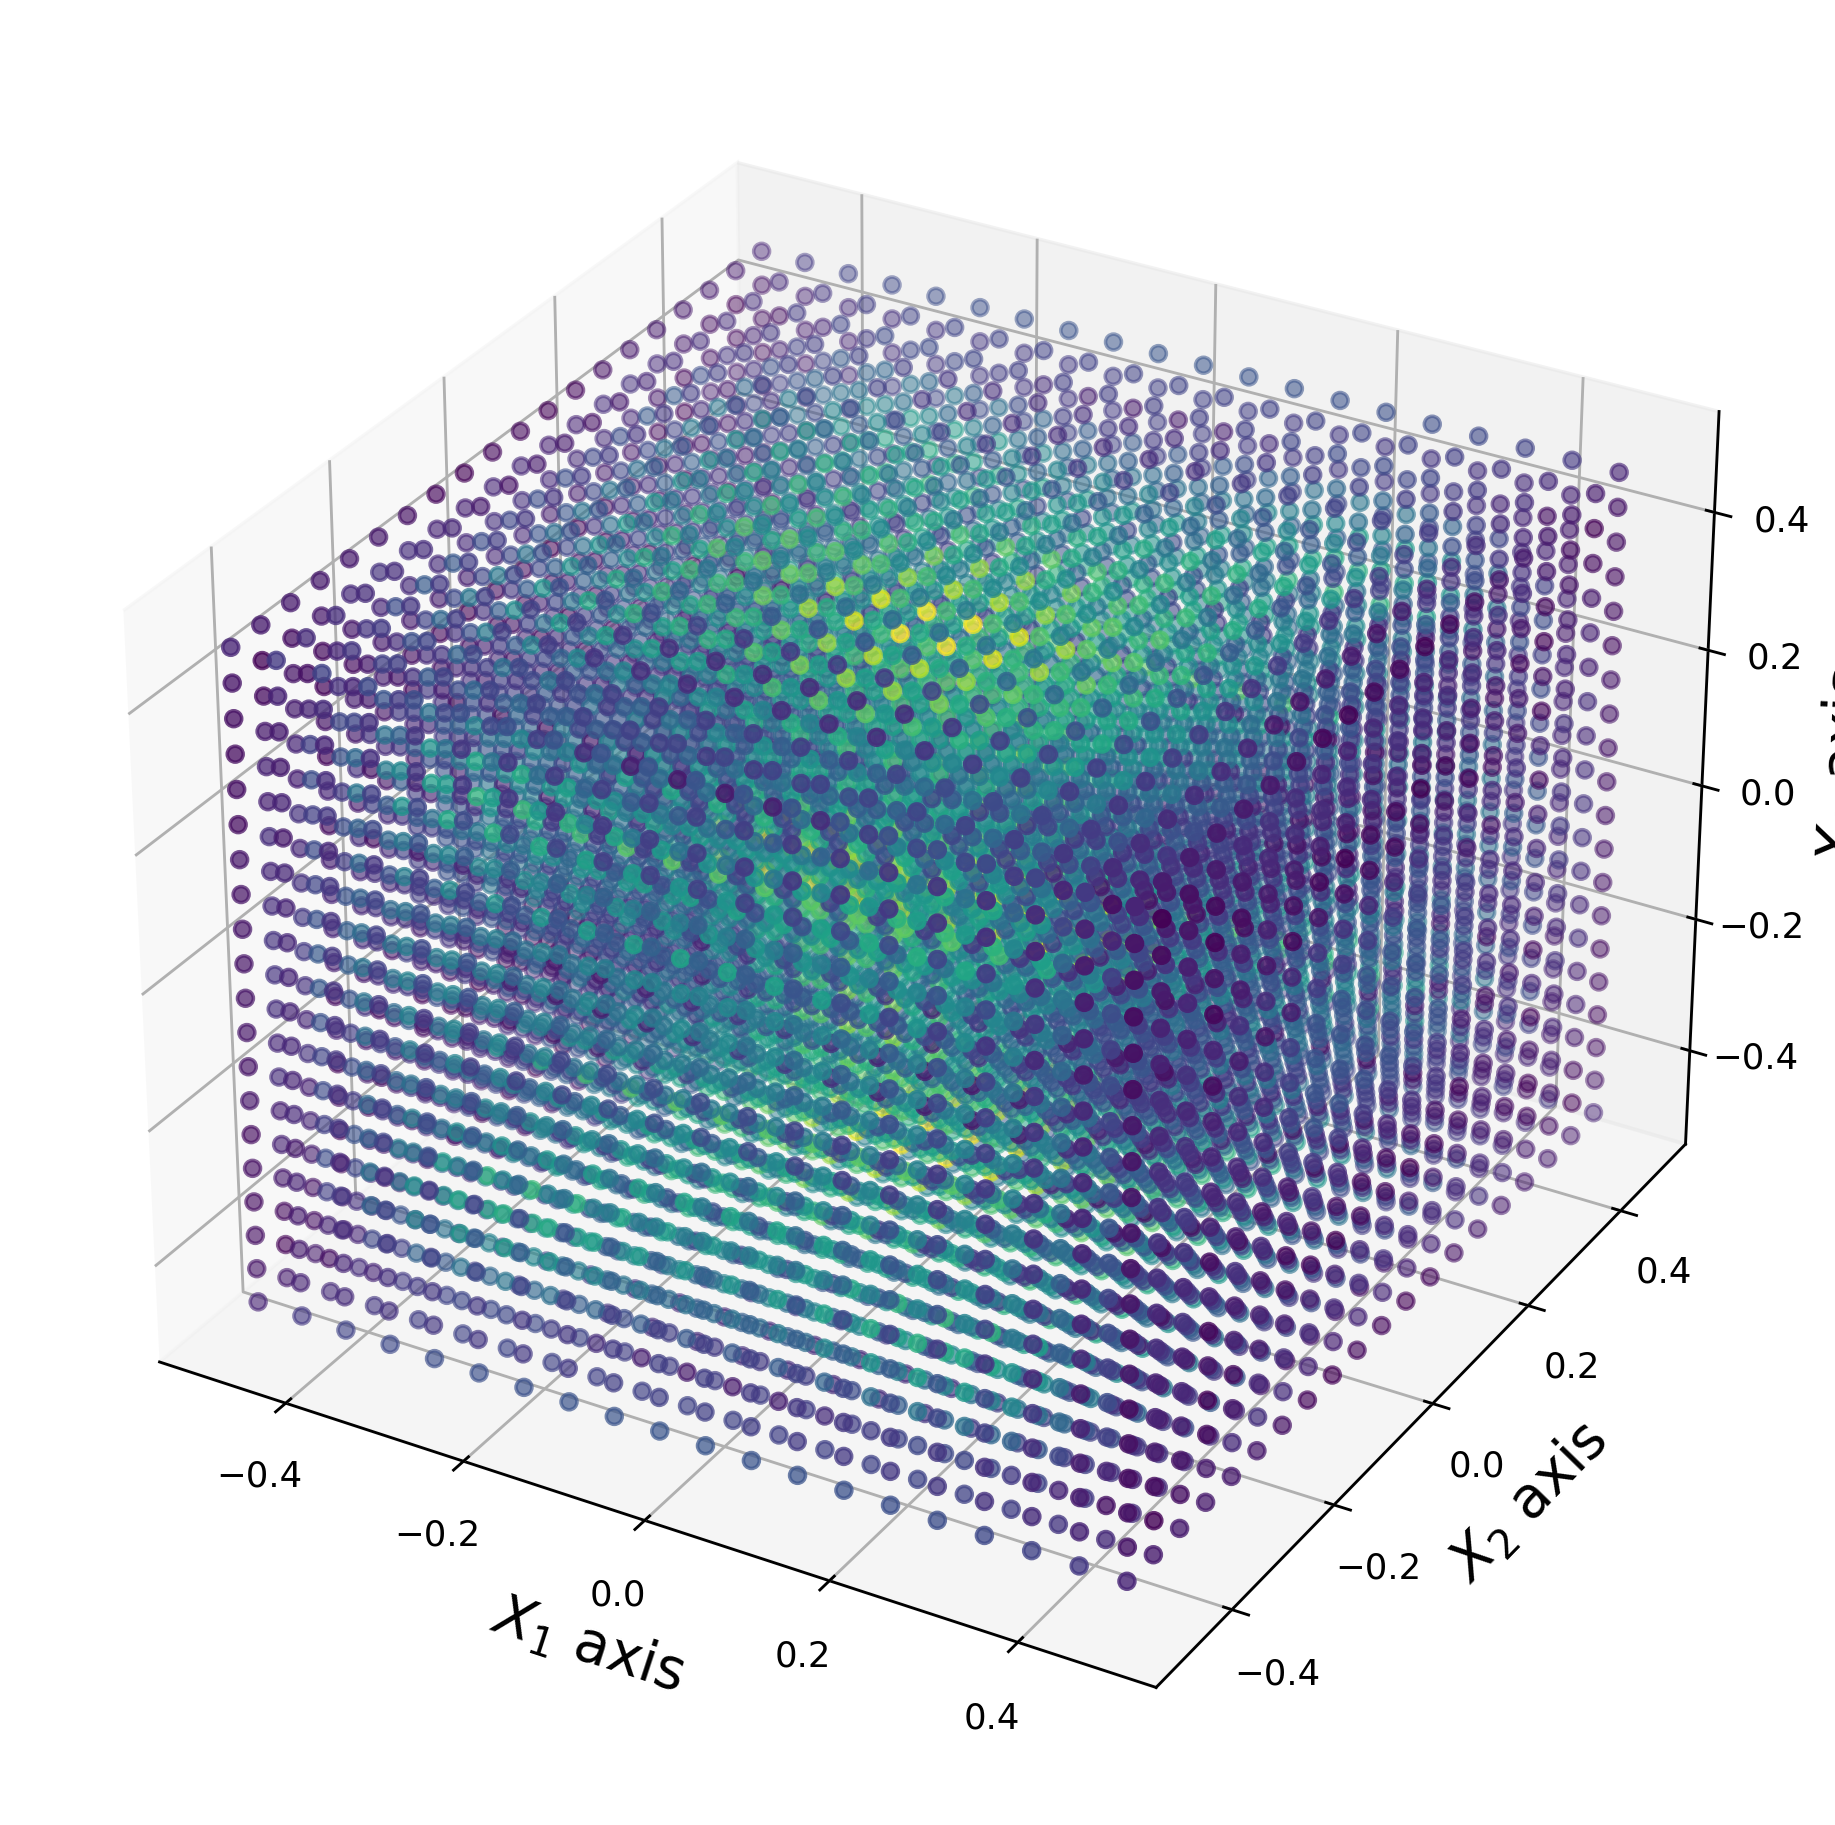

In [130]:
plot_cube_scatter(grid=grid,
                  points=np.linalg.norm(result, axis=1),
                  save_to="wave_modulus.png",
                  show=True)

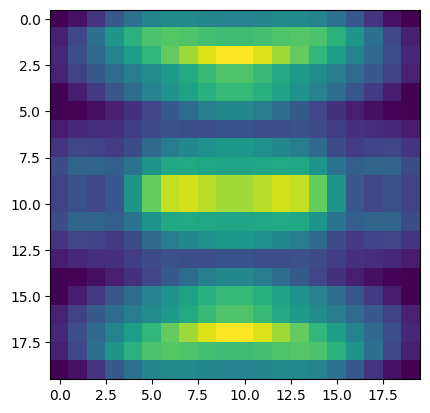

In [131]:
plt.imshow(np.linalg.norm(result, axis=1).reshape(n_1, n_2, n_3)[:, n_2//2, :])

In [132]:
sigmas, angles = compute_RCS(result, eta, grid, ind, vol, k_wave, 300)

# График эффективной поверхности рассеяния для $Q$

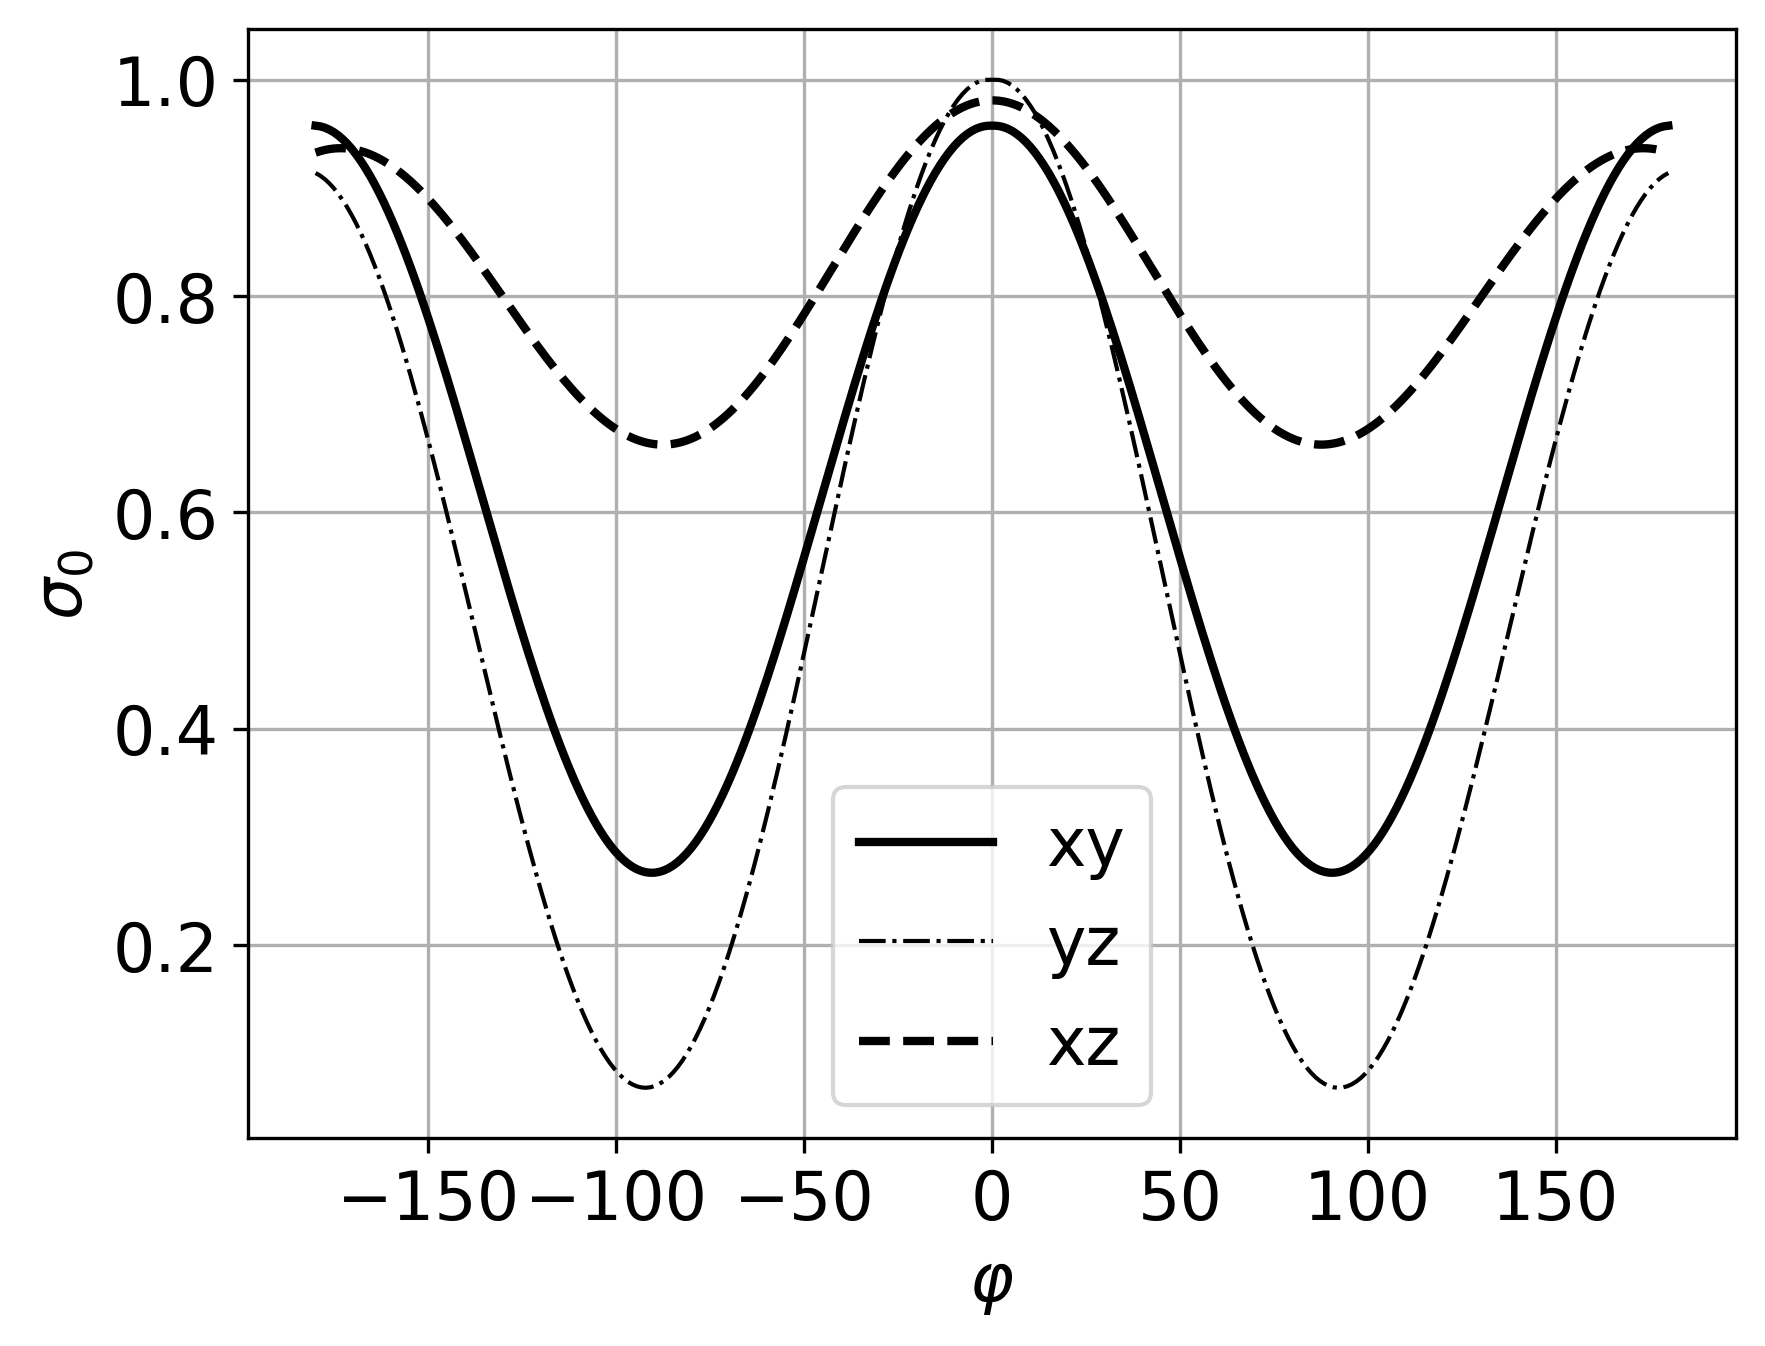

In [133]:
fs = 16

sigmas = [sigmas[0]/np.max(sigmas), sigmas[1]/np.max(sigmas), sigmas[2]/np.max(sigmas)]
rotated = [list(sigmas[0][np.argmax(sigmas[0]) - len(sigmas[0])//2:]) + list(sigmas[0][:np.argmax(sigmas[0]) - len(sigmas[0])//2]),
          list(sigmas[1][np.argmax(sigmas[1]) - len(sigmas[0])//2:]) + list(sigmas[1][:np.argmax(sigmas[1]) - len(sigmas[0])//2]),
          list(sigmas[2][np.argmax(sigmas[2]) - len(sigmas[0])//2:]) + list(sigmas[2][:np.argmax(sigmas[2]) - len(sigmas[0])//2])]
rotated_a = [list(rotated[0][len(rotated[0])//2:][::-1]) + list(rotated[0][len(rotated[0])//2:]),
            list(rotated[1][len(rotated[1])//2:][::-1]) + list(rotated[1][len(rotated[1])//2:]),
            list(rotated[2][len(rotated[2])//2:][::-1]) + list(rotated[2][len(rotated[2])//2:])]                                                        
plt.figure(dpi=300)
plt.plot(angles[0] / np.pi * 180, 
         rotated_a[0], 
         label="xy", linewidth=2, linestyle="-", c= "black")
plt.plot(angles[1] / np.pi * 180, 
         rotated_a[1], 
         label="yz", linewidth=1, linestyle="-.", c= "black")
plt.plot(angles[2] / np.pi * 180, 
         rotated_a[2], 
         label="xz", linewidth=2, linestyle="--", c= "black")
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r"$\varphi$", fontsize=fs)
plt.ylabel(r"$\sigma_0$", fontsize=fs)
plt.grid()

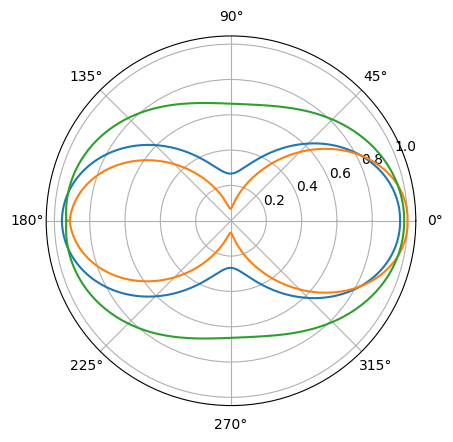

In [137]:
plt.polar(angles[0], rotated_a[0], label="Abs")
plt.polar(angles[1], rotated_a[1], label="Abs")
plt.polar(angles[2], rotated_a[2], label="Abs")